#Máster en Big Data y Data Science: Ciencia e Ingeniería de Datos
### ASIGNATURA: Indexación, búsqueda y análisis en repositorios multimedia
### PARTE: Multimedia (imagen, video)
### Práctica 1: Introducción al diseño de redes neuronales convolucionales con Pytorch mediante Google Colaboratory

---

Autor: Juan C. SanMiguel (juancarlos.sanmiguel@uam.es), Universidad Autónoma de Madrid


# 4. Entrenamiento de una red con CPU (training)

## Preparación del entorno de trabajo



### Pytorch

A continuación tiene un conjunto de instrucciones que instalan el software necesario para esta parte de la práctica.

Para ello se proporciona un fichero *utils.zip* que contiene ficheros y utilidades necesarios.

In [1]:
import os
import subprocess

tmpdir = '/content/tmp/' #temporal location to download and store the dataset

out=subprocess.call(["mkdir",tmpdir]) #create a empty directory
os.chdir(tmpdir) #move to directory

!wget http://www-vpu.eps.uam.es/~jcs/pub/utils.zip -O utils.zip #download utils
!unzip -o -q utils.zip -d . #unzip file

#install software requirements (pytorch, pillow, google-drive-ocamlfuse)
!pip install -r ./utils/requirements.txt

--2019-02-09 10:33:38--  http://www-vpu.eps.uam.es/~jcs/pub/utils.zip
Resolving www-vpu.eps.uam.es (www-vpu.eps.uam.es)... 150.244.57.170
Connecting to www-vpu.eps.uam.es (www-vpu.eps.uam.es)|150.244.57.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2404 (2.3K) [application/zip]
Saving to: ‘utils.zip’

utils.zip           100%[===================>]   2.35K  --.-KB/s    in 0s      

2019-02-09 10:33:38 (417 MB/s) - ‘utils.zip’ saved [2404/2404]



### Rutas de trabajo
En este script, se utilizarán las siguientes rutas

In [0]:
drivedir = '/content/gdrive'
tmpdir = '/content/tmp/' #temporal location to download and store the dataset

pracdir = drivedir + '/My Drive/p1indexacion' #directory for practica 1 indexacion
datadir = pracdir + '/data' #directory for storing datasets
resudir = pracdir + '/result' #directory to save results

### Google Drive

Ejecute el siguiente código para enlazar este script con su cuenta de Google Drive. Los datos que se generen aquí se guardarán en su carpeta Drive para posterior uso. Por defecto, la unidad de Google Drive es enlaza con el directorio **/content/gdrive/**.

In [3]:
from google.colab import drive
drive.mount(drivedir)

print 'Google Drive mount completed'

#check correct mount of drive directory
!df -h

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Google Drive mount completed
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   22G  319G   7% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/sda1       365G   26G  340G   8% /opt/bin
tmpfs           6.4G   12K  6.4G   1% /var/colab
shm             6.0G     0  6.0G   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  1.6M   15G   1% /content/gdrive


## Dataset

En este ejemplo de entrenamiento, vamos a utilizar el dataset *Scenes15*

In [4]:
import subprocess
import os

out=subprocess.call(["mkdir",pracdir])#create directory
out=subprocess.call(["mkdir",datadir])#create directory
out=subprocess.call(["mkdir",resudir])#create directory

os.chdir(datadir) #move to directory

#download and unzip the file
!wget http://www-vpu.eps.uam.es/~jcs/pub/Scene15.zip -O Scene15.zip
!unzip -o -q Scene15.zip -d .

print 'Dataset downloaded and unzipped'

!ls -lah #show directory & file usage

--2019-02-09 10:35:43--  http://www-vpu.eps.uam.es/~jcs/pub/Scene15.zip
Resolving www-vpu.eps.uam.es (www-vpu.eps.uam.es)... 150.244.57.170
Connecting to www-vpu.eps.uam.es (www-vpu.eps.uam.es)|150.244.57.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86395596 (82M) [application/zip]
Saving to: ‘Scene15.zip’

Scene15.zip         100%[===================>]  82.39M  5.41MB/s    in 31s     

2019-02-09 10:36:14 (2.68 MB/s) - ‘Scene15.zip’ saved [86395596/86395596]

Dataset downloaded and unzipped
total 83M
drwx------ 4 root root 4.0K Feb 28  2018 Scene15
-rw------- 1 root root  83M Feb 28  2018 Scene15.zip


Parametros para la generación del dataset

In [0]:
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

#path to the downloaded dataset
dataset_dir = datadir + '/Scene15/'

#number of samples/images per group
batch_size=4

#data transformation
Resizing_factor = (128,128)
transform = transforms.Compose([ transforms.Resize(size=Resizing_factor),                                 
                                transforms.ToTensor()                                
                                ])

#list & load images
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), transform) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#load & convert images to tensors in Python
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

## Creación de la red

A continuación, creamos una red tipo Lenet (modificada para soportar imágenes distintas a 32x32)

In [6]:
import os
#os.chdir(resudir) #move to directory
os.chdir(tmpdir)

#runs script and keeps variables
%run -i ./utils/mylenet.py

# get some random training images to initialize network
images, labels = iter(dataloaders['train']).next()

net = Net(input_shape=images[0].size(), num_outputs=len(class_names))
print(net)

print "Network ready to train!"

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=15, bias=True)
)
Network ready to train!


## Definir una función de coste/optimizador

En este ejemplo utilizamos Cross-Entropy para medir la precisión de nuestro clasificador y SGD como optimizador.

In [0]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Entrenar la red

Ejecución iterativa sobre los datos de entrenamiento/test y actualización de los pesos

In [8]:
import time
import numpy as np
from torch.autograd import Variable

display_batch_iter = 100
number_epochs = 10

epoch_loss =  np.zeros((number_epochs,1))
epoch_train_acc =  np.zeros((number_epochs,1))
epoch_test_acc =  np.zeros((number_epochs,1))  
train_time =  0.0

Ntrain = len(image_datasets['train']) #number of samples for training
Ntest = len(image_datasets['val']) #number of samples for test/validation
    
start = time.time()

print('Training in CPUmode #epochs=%d #batches=%d batchsize=%d' % (number_epochs, len(dataloaders['train']),batch_size))
print('**** Printing loss every %5d batches ****' % (display_batch_iter))  
for epoch in range(number_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        epoch_loss[epoch] += loss.data[0]
        if i % display_batch_iter == display_batch_iter-1:    # print every XXX mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / display_batch_iter))
            running_loss = 0.0

    # compute accuracy on training set
    correct1 = 0.0
    for data in dataloaders['train']:    
      images, labels = data
      outputs = net(Variable(images))
      _, predicted = torch.max(outputs.data, 1)
      correct1 += (predicted == labels).sum()
      
    # compute accuracy on test set
    correct2 = 0.0
    for data in dataloaders['val']:    
      images, labels = data
      outputs = net(Variable(images))
      _, predicted = torch.max(outputs.data, 1)
      correct2 += (predicted == labels).sum()
    
    epoch_loss[epoch] = epoch_loss[epoch] / len(dataloaders['train']) # average loss for each epoch
    epoch_train_acc[epoch] =  100 * correct1 / Ntrain   # average train accuracy for each epoch
    epoch_test_acc[epoch]  =  100 * correct2 / Ntest    # average test accuracy for each epoch
    print('Epoch %02d, loss: %1.3f, accuracy train: %2.3f %% (correct %04d total %04d ) accuracy test: %2.3f %% (correct %04d total %04d )' % (epoch + 1, epoch_loss[epoch], epoch_train_acc[epoch], correct1, Ntrain, epoch_test_acc[epoch], correct2, Ntest ))
    
train_time = time.time() - start
print('Finished Training (' + str(train_time) + ' secs)')

Training in CPUmode #epochs=10 #batches=375 batchsize=4
**** Printing loss every   100 batches ****
[1,   100] loss: 2.711
[1,   200] loss: 2.712
[1,   300] loss: 2.711
Epoch 01, loss: 2.710, accuracy train: 6.667 % (correct 0100 total 1500 ) accuracy test: 6.265 % (correct 0187 total 2985 )
[2,   100] loss: 2.707
[2,   200] loss: 2.697
[2,   300] loss: 2.697
Epoch 02, loss: 2.696, accuracy train: 13.867 % (correct 0208 total 1500 ) accuracy test: 9.514 % (correct 0284 total 2985 )
[3,   100] loss: 2.653
[3,   200] loss: 2.608
[3,   300] loss: 2.594
Epoch 03, loss: 2.600, accuracy train: 16.000 % (correct 0240 total 1500 ) accuracy test: 10.586 % (correct 0316 total 2985 )
[4,   100] loss: 2.499
[4,   200] loss: 2.488
[4,   300] loss: 2.497
Epoch 04, loss: 2.500, accuracy train: 20.200 % (correct 0303 total 1500 ) accuracy test: 14.171 % (correct 0423 total 2985 )
[5,   100] loss: 2.483
[5,   200] loss: 2.385
[5,   300] loss: 2.444
Epoch 05, loss: 2.445, accuracy train: 21.933 % (corre

Finalmente podemos guardar los datos tras el entrenamiento en nuestra carpeta de Google Drive

In [9]:
#@title
#save results in a single file
import pickle
import os
import subprocess

out=subprocess.call(["mkdir",resudir])#create directory
os.chdir(resudir) #move to drive directory

# Saving the objects:
f = open('training_baseline_results_epochs_'+ str(number_epochs) +'.pkl', 'wb')
pickle.dump([epoch_train_acc, epoch_test_acc, epoch_loss, train_time, number_epochs, batch_size], f)
f.close()
print('Saved data')

Saved data


Posteriormente, si quisieramos recuperar las variables/objetos para analizar, utilizaremos el siguiente código

In [0]:
#get results from a single file
import pickle
import os
os.chdir(resudir) #move to drive directory

# Load the objects
f = open('training_baseline_results_epochs_10.pkl', 'rb')
epoch_train_acc, epoch_test_acc, epoch_loss, train_time, number_epochs, batch_size = pickle.load(f)

## Resultados tras entrenamiento 



### Análisis de precisión y función de pérdidas
A continuación pintamos las variables que hemos acumulado durante el entrenamiento.

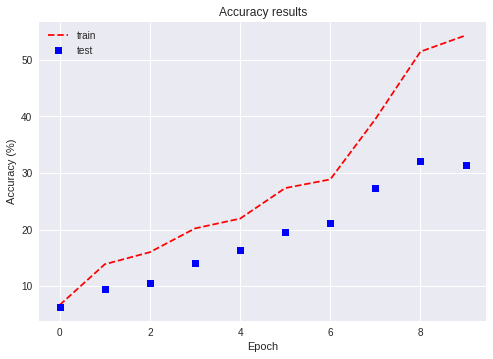

In [12]:
import matplotlib.pyplot as plt

t = range(number_epochs)
lineObjects =plt.plot(t,epoch_train_acc,'r--',t,epoch_test_acc,'bs')
plt.legend(lineObjects, ('train', 'test'))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy results') 

import os
os.chdir(resudir) #move to drive directory for saving data

plt.savefig('training_accuracy_baseline__epochs'+ str(number_epochs) + '_CPU.png',bbox_inches='tight')#call this function before "plt.show()"
plt.show()

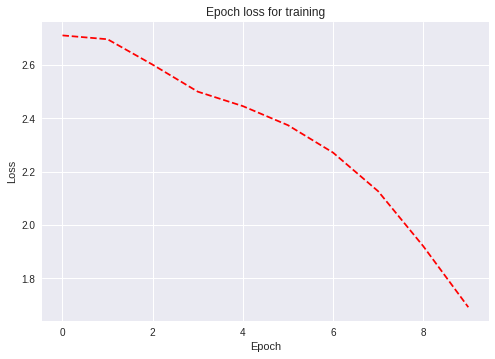

In [13]:
import matplotlib.pyplot as plt

t = range(number_epochs)
plt.plot(t,epoch_loss,'r--')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Epoch loss for training') 
plt.show()

### Ejemplos de resultado

Es recomendable repasar los resultados obtenidos tanto gráficamente como estadísticamente.

Primero, seleccionamos algunos datos y visualmente verificamos errores:


('GroundTruth: ', 'OpenCountry Forest Highway Street')
('Predicted: ', 'Coast Mountain OpenCountry Street')


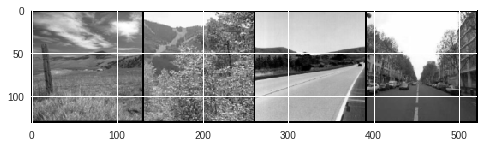

In [14]:
import torchvision

# function to show an image
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize if normalization is done in transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
#get sample data
images, labels = iter(dataloaders['val']).next()
   
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(batch_size)))

Posteriormente estudiamos los resultados para cada clase

In [15]:
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))
for data in dataloaders['val']:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

class_totalT = 0
for i in range(len(class_names)):
    print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))
    class_totalT += class_total[i]
print('Total test data = %d images' % (class_totalT))

Accuracy of Bedroom : 34 %
Accuracy of Coast : 35 %
Accuracy of Forest : 31 %
Accuracy of Highway : 61 %
Accuracy of Industrial : 17 %
Accuracy of InsideCity :  5 %
Accuracy of Kitchen : 19 %
Accuracy of LivingRoom : 38 %
Accuracy of Mountain : 37 %
Accuracy of Office : 25 %
Accuracy of OpenCountry : 25 %
Accuracy of Store :  3 %
Accuracy of Street : 43 %
Accuracy of Suburb : 49 %
Accuracy of TallBuilding : 48 %
Total test data = 2985 images
